
# Second task, energy part
- Build a dataset of spin glass graphs with a fixed number of nodes (10) and compare the learning capability of a GNN and a MLP.

### Table of contents:
1. [Dataset preparation](#dataset)
2. [Model and functions definitions](#model)
3. [Training of the model](#training)




In [27]:
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import torch.nn.functional as F

import torchsummary

import os 

#import standard Dataloader

from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Linear



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

Device:  cuda


In [28]:
# set standard dimensions for the plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# Dataset preparation  <a class="anchor" id="dataset"></a>

In order to train a MLP, we need extract the adjacency matrix and the nodes features from the graphs and store them into a 1D tensor.

In [42]:
# parameters for the dataset
n_nodes = 10
h = 0
n_samples = 5000
path = f"datasets"


n_dimensions_list = [1,2,3,4,5]
periodic_list = [True, False]

dataset_list = []
graphs_list = []
n_connections_list = []


for dim in n_dimensions_list:
    for periodic in periodic_list:
        dataset = torch.load(f"{path}/dataset_{n_nodes}_{h}_{periodic}_{dim}_{n_samples}.pt")
        graphs = torch.load(f"{path}/graphs_{n_nodes}_{h}_{periodic}_{dim}_{n_samples}.pt")
        n_connections = len(graphs[0].edges)
        print(f"loading dataset with dimension {dim} and periodic {periodic} with {n_connections} connections")
        dataset_list.append(dataset)
        graphs_list.append(graphs)
        n_connections_list.append(n_connections)

loading dataset with dimension 1 and periodic True with 10 connections
loading dataset with dimension 1 and periodic False with 9 connections
loading dataset with dimension 2 and periodic True with 20 connections
loading dataset with dimension 2 and periodic False with 17 connections
loading dataset with dimension 3 and periodic True with 30 connections
loading dataset with dimension 3 and periodic False with 24 connections
loading dataset with dimension 4 and periodic True with 40 connections
loading dataset with dimension 4 and periodic False with 30 connections
loading dataset with dimension 5 and periodic True with 45 connections
loading dataset with dimension 5 and periodic False with 35 connections


In [43]:
# preapare the data for the MLP

features_list = []
labels_list = []

for dataset, graphs in zip(dataset_list, graphs_list):
    features = []
    labels = []

    for data, graph in zip(dataset, graphs):
        X = data.x # extract the features from the data
        A = nx.adjacency_matrix(graph).toarray()  # extract the adjacency matrix from the graph
        features.append(torch.cat((X, torch.tensor(A).float() ), dim=1)) 
        labels.append(data.y)
    features_list.append(features)
    labels_list.append(labels)


# print features[0] 
print("input feature: ")
print(features[0].detach().numpy().round(2))

print("label: ")
print(labels[0].detach().numpy())

input feature: 
[[-1.    0.    0.02 -0.81 -0.13 -0.73 -0.5   0.    0.    0.    0.  ]
 [-1.    0.02  0.    0.09 -0.68  0.11  0.69  0.9   0.    0.    0.  ]
 [-1.   -0.81  0.09  0.    0.93  0.87 -0.23  0.27  0.1   0.    0.  ]
 [ 1.   -0.13 -0.68  0.93  0.   -0.35 -0.8   0.87  0.55  0.47  0.  ]
 [-1.   -0.73  0.11  0.87 -0.35  0.   -0.76 -0.88 -0.85 -0.47  0.18]
 [ 1.   -0.5   0.69 -0.23 -0.8  -0.76  0.    0.52  0.88 -0.09  0.48]
 [-1.    0.    0.9   0.27  0.87 -0.88  0.52  0.   -0.35  0.56 -0.62]
 [ 1.    0.    0.    0.1   0.55 -0.85  0.88 -0.35  0.   -0.23  0.62]
 [ 1.    0.    0.    0.    0.47 -0.47 -0.09  0.56 -0.23  0.    0.3 ]
 [ 1.    0.    0.    0.    0.    0.18  0.48 -0.62  0.62  0.3   0.  ]]
label: 
[-1.5583096]


# Model and functions definitions <a class="anchor" id="model"></a>
In this section I've defined the function used to build the MLP model and train it. 

In [49]:
 
def plot_loss( train_losses, test_losses):
    fig = plt.figure()
    epoch = range(1, len(train_losses)+1)
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig

# show the scatter plot of the predictions
def plot_scatter(testloader, mse, n_connections, model_name):

    predictions = []
    true_value = []

    for i, mini_batch in enumerate(test_loader):
        data = mini_batch[0]
        true_value.append(mini_batch[1])
        data = data.to(device)
        prediction = model.forward(data)
        predictions.append(prediction)

    
    plt.plot(true_value, true_value, color='red')
    plt.xlabel('True energy')
    plt.ylabel('Predicted energy')
    plt.title(f"Predicted vs True energy with {n_connections} connections")

    at = AnchoredText(f"MSE: {str(mse)}", frameon=True, loc='upper left')
    plt.gca().add_artist(at)

    # plot a box similar to the legend to show the MSE
    plt.grid(True)
    plt.show()

    # save the plot
    plt.savefig(f"{model_name}_scatter_ {n_connections}.png")




def train_MLP(model, train_loader, test_loader, num_epochs, patience = 5, model_name='best_model', verbose = True, device= None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # parameters for patience
    best_loss = np.inf
    patience_counter = 0


    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    
    print('Training ...')

    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            # add the batch to the device
            #mini_batch.to(device)
            # train the model
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                #mini_batch.to(device)
                data = mini_batch[0]
                labels = mini_batch[1]
                data, labels = data.to(device), labels.to(device)

                prediction = model.forward(data)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, labels).item()
                test_loss_per_epoch.append(test_loss)
            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))
            
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), model_name + '_model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        if verbose:
            print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")


    return  train_losses, test_losses

In [32]:
# create a feedforward MLP

class MLP(torch.nn.Module):
    """
    A simple feedforward neural network with a tunable number of hidden layers
    inputs:
    - in_channels: number of input features
    - hidden_channels_1: number of neurons in the first hidden layer
    - hidden_channels_2: number of neurons in the second hidden layer
    - hidden_channels_3: number of neurons in the third hidden layer
    - out_channels: number of output features
    - dropout: dropout rate
    - lr: learning rate
    - wd: weight decay
    - hidden_layers: number of hidden layers

    outputs:
    - forward pass
    - train_step

    """
    def __init__(self, in_channels, hidden_channels_1, hidden_channels_2, hidden_channels_3, out_channels=1, dropout=0.2, lr = 0.01, wd = 0.0005, hidden_layers = 2):
        super(MLP, self).__init__()
        self.lin1 = Linear(in_channels, hidden_channels_1)
        self.lin2 = Linear(hidden_channels_1, hidden_channels_2)
        self.lin3 = Linear(hidden_channels_2, hidden_channels_3)
        self.lin4 = Linear(hidden_channels_3, out_channels)

        self.dropout = torch.nn.Dropout(dropout)


        self.hidden_layers = hidden_layers           # tunable number of hidden layers 
        self.hidden_channels_2 = hidden_channels_2
        self.hidden_channels_3 = hidden_channels_3

        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr , weight_decay= wd)

    def forward(self, x):

        #print(f"Input size: {x.shape}")
        
        x = F.relu(self.lin1(x))
        #print(f"Layer 1 output size: {x.shape}")

        x = self.dropout(x)
        x = F.relu(self.lin2(x))
        #print(f"Layer 2 output size: {x.shape}")

        if self.hidden_layers ==2:
            x = self.dropout(x)
            x = F.relu(self.lin3(x))
            #print(f"Layer 3 output size: {x.shape}")
        
        elif self.hidden_channels_2 != self.hidden_channels_3:
            print("Error: hidden_channels_2 != hidden_channels_3")
            return None

        x = self.dropout(x)
        x = self.lin4(x)
        #print(f"Output size: {x.shape}")

        return x
    
    def train_step(self, data):
        # load the data into the device
        input_data = data[0].to(device)
        label = data[1].to(device)

        #print(f"input data: {input_data.shape} \n label: {label.shape} \n")
        
        # reset the gradients
        self.optimizer.zero_grad()

        # forward pass
        output = self.forward(input_data)

        # reshape the output and the label
        #output = output.view(-1)
        #label = label.view(-1)
        #print(f"output: {output} \n label: {label} \n")
        
        # compute the loss
        loss = self.criterion(output, label)
        # backward pass
        loss.backward()
        # update the weights
        self.optimizer.step()

        return loss.item()


In [33]:
# training parameters

# set standard parameters for the model

# parameters for the dataset
batchsize = 32

# parameters for the model
num_epochs = 30
lr = 1e-3
weight_decay = 1e-4
dropout = 0.0
patience = 5

# parameters for the layers
input_channels = 110
hidden_channels_1 = 64
hidden_channels_2 = 64
hidden_channels_3 = 32

hidden_layers = 2  # 1 or 2



In [44]:
# create dataloaders for the training and the test set, converting the features into a 1d tensor
trainloader_list = []
testloader_list = []

for features, labels in zip(features_list, labels_list):
    features = [torch.flatten(f) for f in features]
    labels = [torch.flatten(l) for l in labels]  # it should be already a 1d tensor

    # split the dataset into training and test set
    n_train = int(0.8*len(features))
    n_test = len(features) - n_train

    train_dataset = TensorDataset(torch.stack(features[:n_train]), torch.stack(labels[:n_train]))
    test_dataset = TensorDataset(torch.stack(features[n_train:]), torch.stack(labels[n_train:]))

    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

    trainloader_list.append(train_loader)
    testloader_list.append(test_loader)



In [56]:
input_channels = features[0].shape[0]   # flatten the input

model = MLP(in_channels=input_channels,
            hidden_channels_1=hidden_channels_1, 
            hidden_channels_2=hidden_channels_2,
            hidden_channels_3=hidden_channels_3,
            out_channels=1,
            dropout=dropout,
            lr=lr,
            wd=weight_decay,
            hidden_layers=hidden_layers
            )

model.to(device)

torchsummary.summary(model, input_size=(features[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           7,104
           Dropout-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
           Dropout-4                   [-1, 64]               0
            Linear-5                   [-1, 32]           2,080
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


# Training of the model <a class="anchor" id="training"></a>


In [75]:
def test_trained_model(model, test_loader, device = None, ax_name = "energy"):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)

    fig = plt.figure()
    with torch.no_grad():
        predictions = []
        true_value = []
        for i, mini_batch in enumerate(test_loader):
            data = mini_batch[0]
            true_value.append(mini_batch[1])
            data = data.to(device)
            prediction = model.forward(data)
            predictions.append(prediction)

        predictions = torch.cat(predictions).to("cpu").detach().numpy()
        true_values = torch.cat(true_value).detach().numpy()

        
        # save the mean squared error
        mse = np.mean((np.array(predictions) - np.array(true_values))**2).round(2)
       
        plt.scatter(true_values, predictions)
        plt.plot(true_values, true_values, color='red')
        plt.xlabel('True ' + ax_name)
        plt.ylabel('Predicted' + ax_name)
        plt.title('Predicted vs True ' + ax_name)
    
        at = AnchoredText(f"MSE: {mse}", frameon=True, loc='upper left')
        plt.gca().add_artist(at)

        # plot a box similar to the legend to show the MSE
        plt.grid(True)
        plt.show()
    
    

    return fig, mse

Training ...
Ep 1 	| Loss 0.81782 	| Test Loss 0.80439
Ep 2 	| Loss 0.80813 	| Test Loss 0.79472
Ep 3 	| Loss 0.77848 	| Test Loss 0.76246
Ep 4 	| Loss 0.68558 	| Test Loss 0.73164
Ep 5 	| Loss 0.54088 	| Test Loss 0.58468
Ep 6 	| Loss 0.4074 	| Test Loss 0.48134
Ep 7 	| Loss 0.30957 	| Test Loss 0.41778
Ep 8 	| Loss 0.23651 	| Test Loss 0.35956
Ep 9 	| Loss 0.18824 	| Test Loss 0.31538
Ep 10 	| Loss 0.15544 	| Test Loss 0.29559
Ep 11 	| Loss 0.12657 	| Test Loss 0.27044
Ep 12 	| Loss 0.1072 	| Test Loss 0.2511
Ep 13 	| Loss 0.0966 	| Test Loss 0.21876
Ep 14 	| Loss 0.08526 	| Test Loss 0.20938
Ep 15 	| Loss 0.07637 	| Test Loss 0.21343
Ep 16 	| Loss 0.06818 	| Test Loss 0.18702
Ep 17 	| Loss 0.06338 	| Test Loss 0.19246
Ep 18 	| Loss 0.06081 	| Test Loss 0.18377
Ep 19 	| Loss 0.05414 	| Test Loss 0.17893
Ep 20 	| Loss 0.05172 	| Test Loss 0.1802
Ep 21 	| Loss 0.04869 	| Test Loss 0.1688
Ep 22 	| Loss 0.04522 	| Test Loss 0.16584
Ep 23 	| Loss 0.04267 	| Test Loss 0.17426
Ep 24 	| Loss

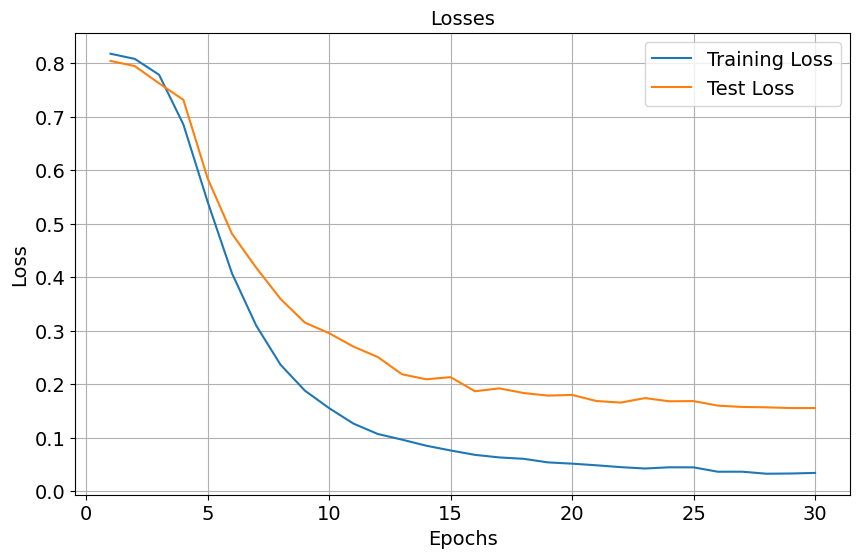

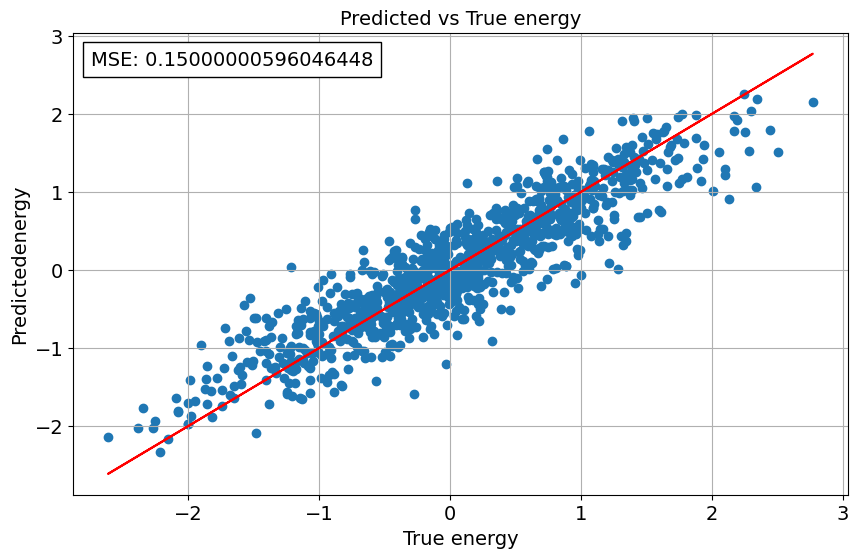

Finished training for dataset with dimension with 10 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 0.74866 	| Test Loss 0.72653
Ep 2 	| Loss 0.73749 	| Test Loss 0.72037
Ep 3 	| Loss 0.70542 	| Test Loss 0.69208
Ep 4 	| Loss 0.60112 	| Test Loss 0.59566
Ep 5 	| Loss 0.43883 	| Test Loss 0.44446
Ep 6 	| Loss 0.30484 	| Test Loss 0.37143
Ep 7 	| Loss 0.21294 	| Test Loss 0.3089
Ep 8 	| Loss 0.1608 	| Test Loss 0.23069
Ep 9 	| Loss 0.12172 	| Test Loss 0.20702
Ep 10 	| Loss 0.09596 	| Test Loss 0.16748
Ep 11 	| Loss 0.07897 	| Test Loss 0.16398
Ep 12 	| Loss 0.06838 	| Test Loss 0.13922
Ep 13 	| Loss 0.06221 	| Test Loss 0.13983
Ep 14 	| Loss 0.05256 	| Test Loss 0.13359
Ep 15 	| Loss 0.05034 	| Test Loss 0.12075
Ep 16 	| Loss 0.04646 	| Test Loss 0.12838
Ep 17 	| Loss 0.04268 	| Test Loss 0.11605
Ep 18 	| Loss 0.03718 	| Tes

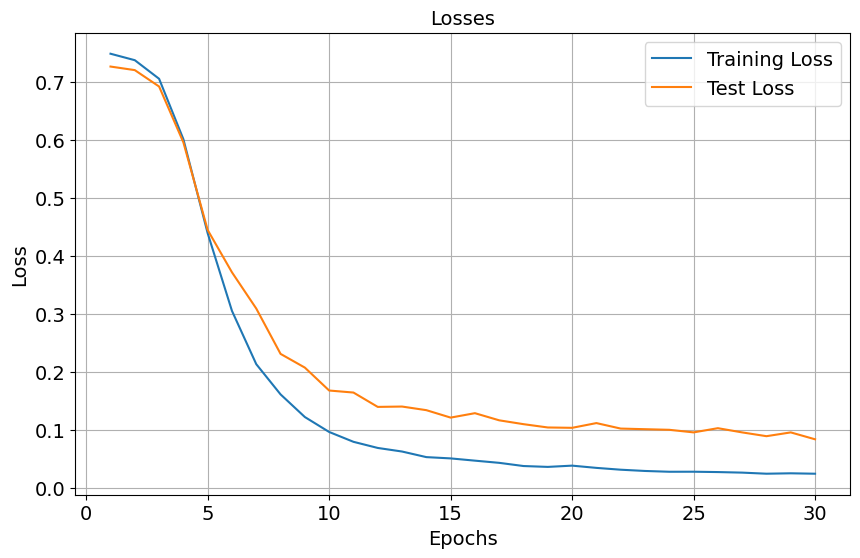

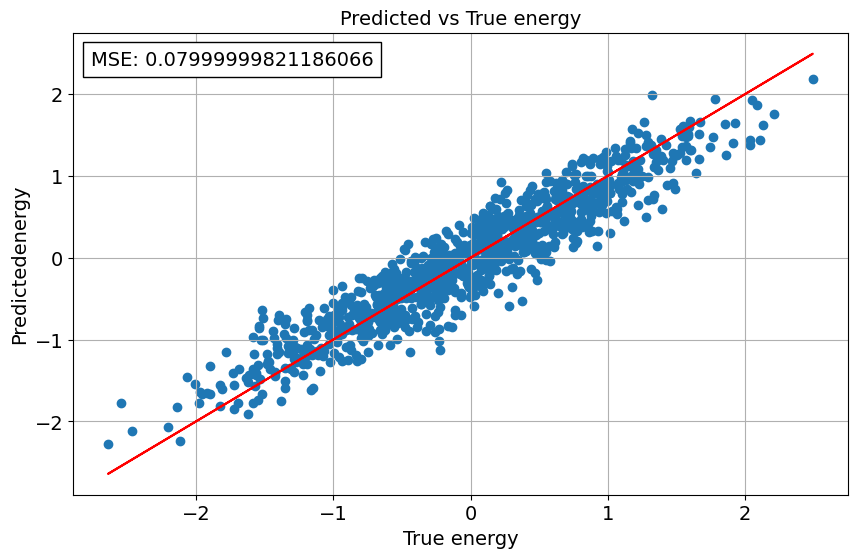

Finished training for dataset with dimension with 9 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 1.73773 	| Test Loss 1.65867
Ep 2 	| Loss 1.7237 	| Test Loss 1.65019
Ep 3 	| Loss 1.69153 	| Test Loss 1.63297
Ep 4 	| Loss 1.61337 	| Test Loss 1.62749
Ep 5 	| Loss 1.48018 	| Test Loss 1.60934
Ep 6 	| Loss 1.31219 	| Test Loss 1.59229
Ep 7 	| Loss 1.1533 	| Test Loss 1.62069
Ep 8 	| Loss 1.01679 	| Test Loss 1.60962
Ep 9 	| Loss 0.88422 	| Test Loss 1.60305
Ep 10 	| Loss 0.78902 	| Test Loss 1.52081
Ep 11 	| Loss 0.6951 	| Test Loss 1.48416
Ep 12 	| Loss 0.61932 	| Test Loss 1.51098
Ep 13 	| Loss 0.56572 	| Test Loss 1.51644
Ep 14 	| Loss 0.51093 	| Test Loss 1.53141
Ep 15 	| Loss 0.46886 	| Test Loss 1.50387
Early stopping at epoch 16


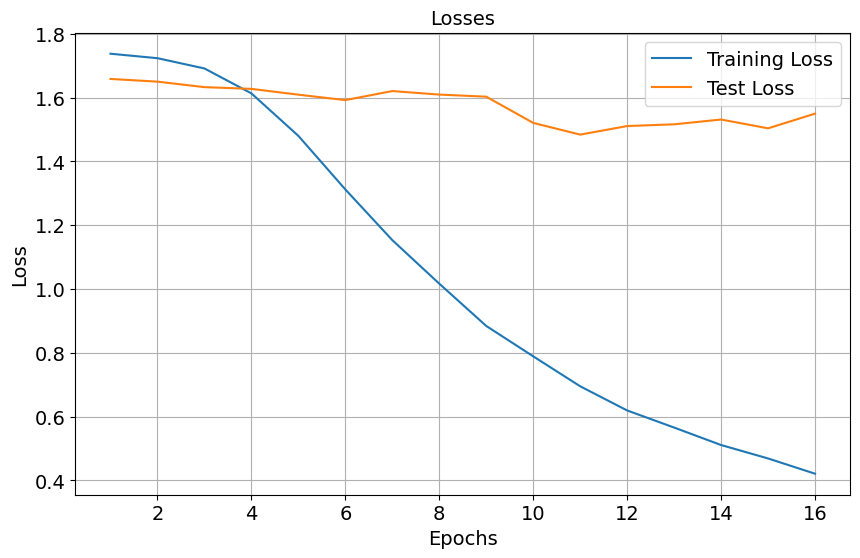

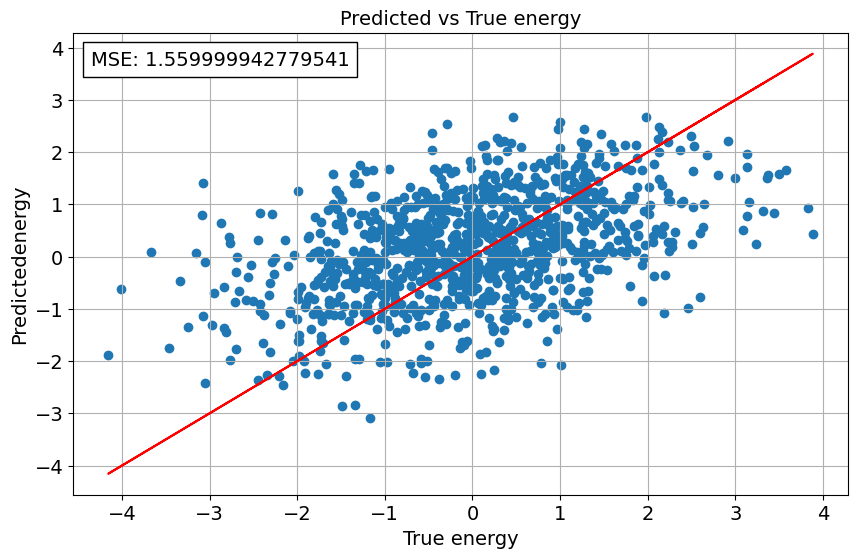

Finished training for dataset with dimension with 20 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 1.38994 	| Test Loss 1.38347
Ep 2 	| Loss 1.3799 	| Test Loss 1.38349
Ep 3 	| Loss 1.35639 	| Test Loss 1.37978
Ep 4 	| Loss 1.29268 	| Test Loss 1.35293
Ep 5 	| Loss 1.16489 	| Test Loss 1.33935
Ep 6 	| Loss 1.00917 	| Test Loss 1.27728
Ep 7 	| Loss 0.85689 	| Test Loss 1.19896
Ep 8 	| Loss 0.72277 	| Test Loss 1.12533
Ep 9 	| Loss 0.60798 	| Test Loss 1.07326
Ep 10 	| Loss 0.53423 	| Test Loss 1.07764
Ep 11 	| Loss 0.46464 	| Test Loss 1.0605
Ep 12 	| Loss 0.41778 	| Test Loss 1.08977
Ep 13 	| Loss 0.36643 	| Test Loss 1.03098
Ep 14 	| Loss 0.33833 	| Test Loss 1.08984
Ep 15 	| Loss 0.31156 	| Test Loss 1.0347
Ep 16 	| Loss 0.28374 	| Test Loss 1.03529
Ep 17 	| Loss 0.2536 	| Test Loss 1.05446
Early stopping at epoch 18


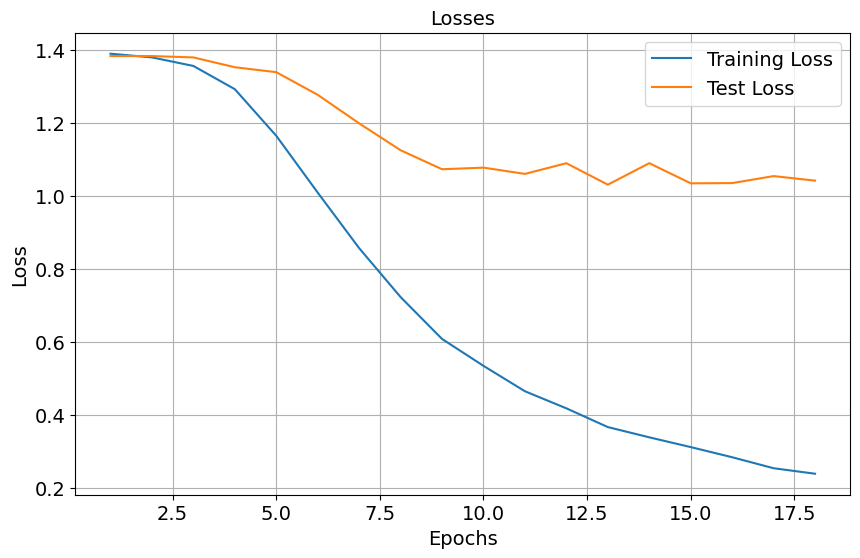

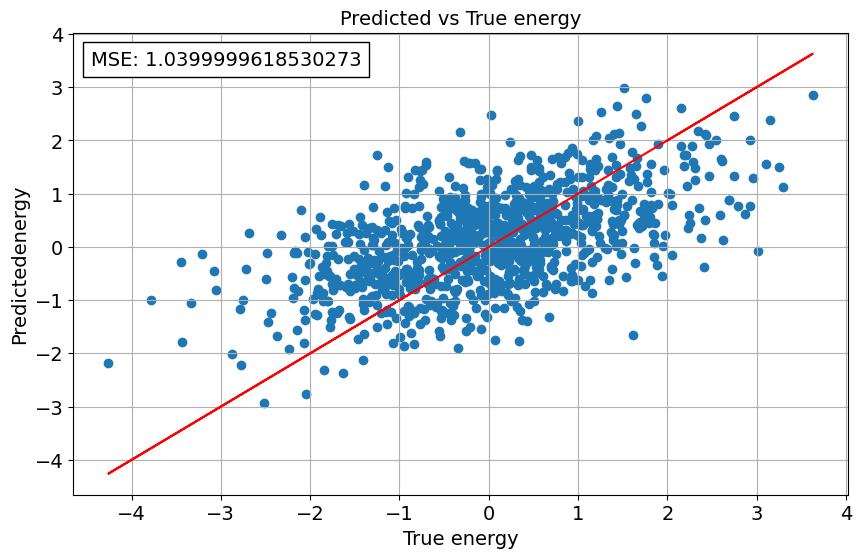

Finished training for dataset with dimension with 17 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 2.579 	| Test Loss 2.54361
Ep 2 	| Loss 2.55916 	| Test Loss 2.58317
Ep 3 	| Loss 2.50917 	| Test Loss 2.59932
Ep 4 	| Loss 2.42545 	| Test Loss 2.64055
Ep 5 	| Loss 2.26933 	| Test Loss 2.77387
Early stopping at epoch 6


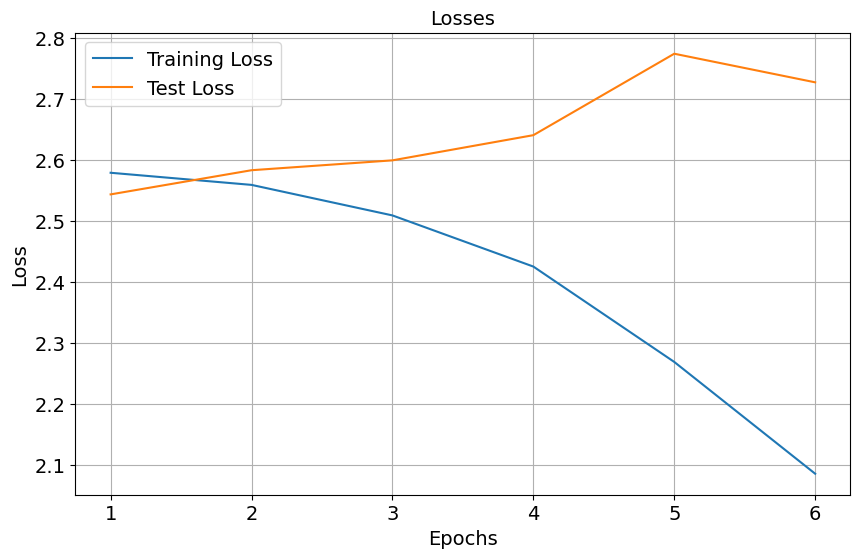

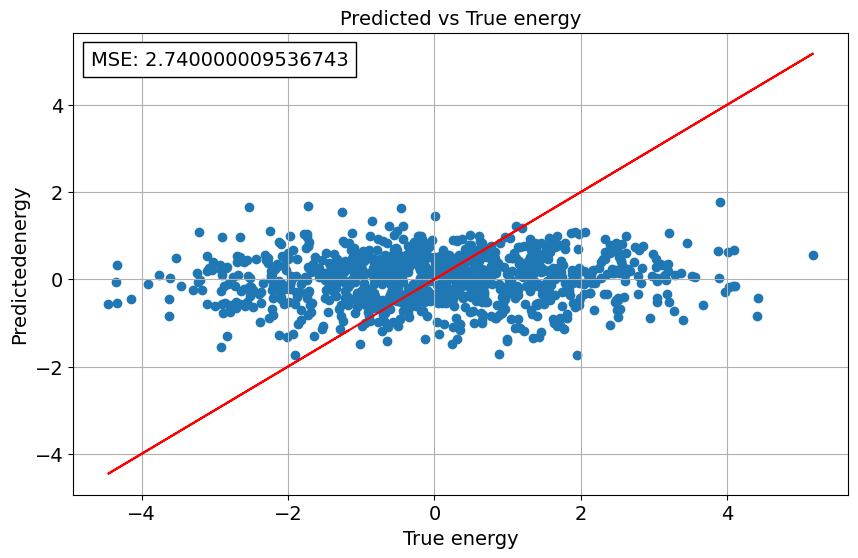

Finished training for dataset with dimension with 30 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 1.99045 	| Test Loss 1.95436
Ep 2 	| Loss 1.97112 	| Test Loss 1.9432
Ep 3 	| Loss 1.93799 	| Test Loss 1.92286
Ep 4 	| Loss 1.87951 	| Test Loss 1.97261
Ep 5 	| Loss 1.76568 	| Test Loss 1.99936
Ep 6 	| Loss 1.59052 	| Test Loss 1.89207
Ep 7 	| Loss 1.38978 	| Test Loss 1.80625
Ep 8 	| Loss 1.20216 	| Test Loss 1.84661
Ep 9 	| Loss 1.03048 	| Test Loss 1.93032
Ep 10 	| Loss 0.90697 	| Test Loss 1.86386
Ep 11 	| Loss 0.80947 	| Test Loss 1.95725
Early stopping at epoch 12


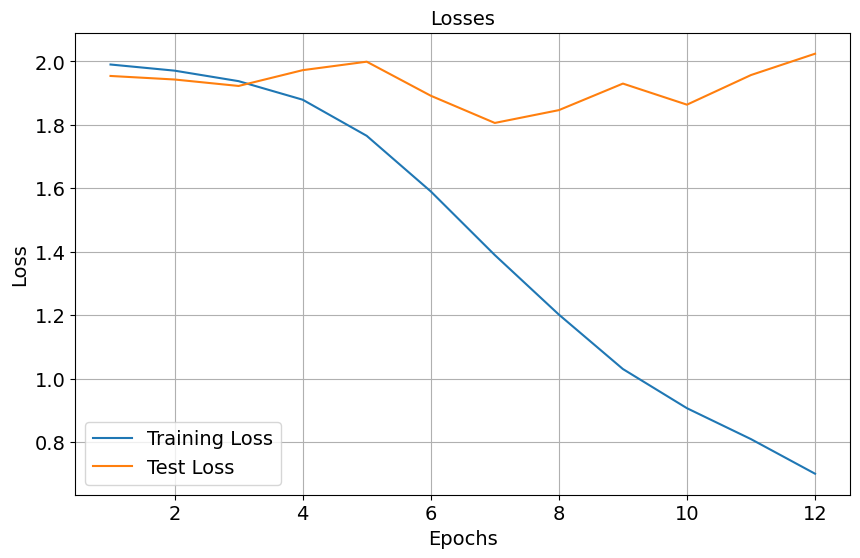

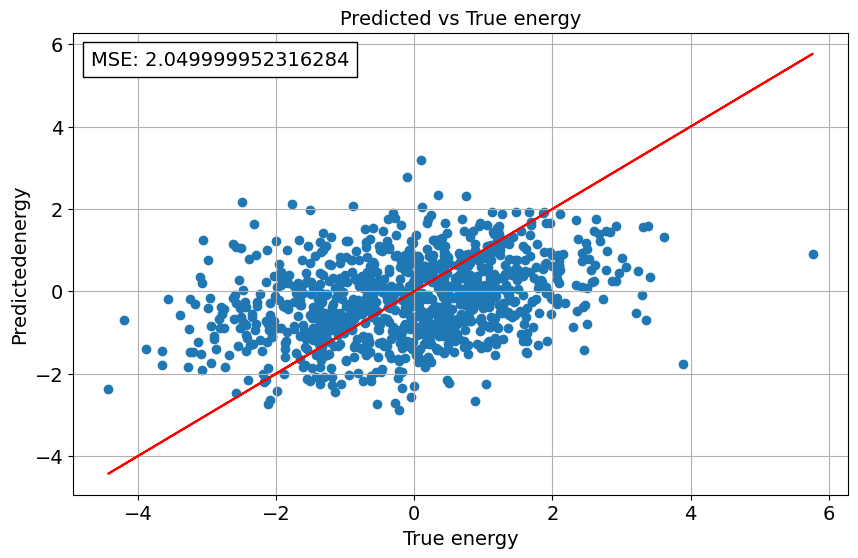

Finished training for dataset with dimension with 24 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 3.52393 	| Test Loss 3.365
Ep 2 	| Loss 3.49396 	| Test Loss 3.3829
Ep 3 	| Loss 3.44159 	| Test Loss 3.43524
Ep 4 	| Loss 3.29724 	| Test Loss 3.49465
Ep 5 	| Loss 3.06338 	| Test Loss 3.73399
Early stopping at epoch 6


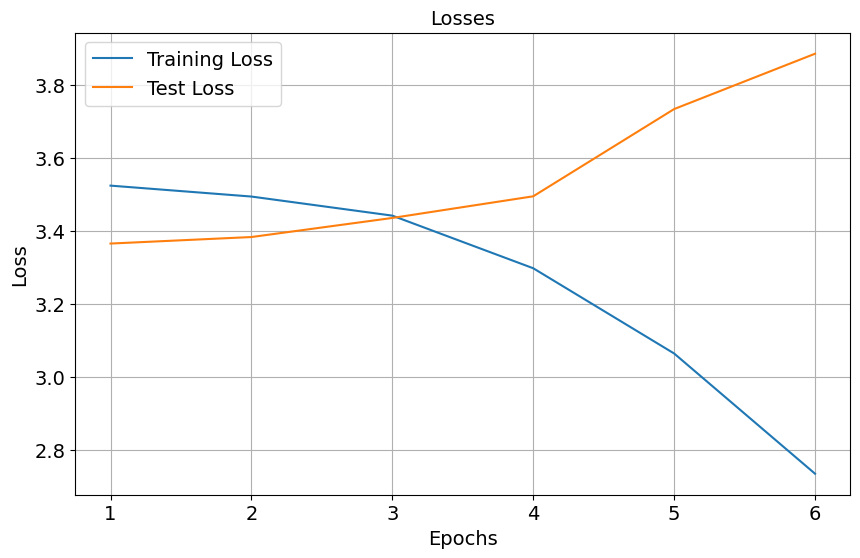

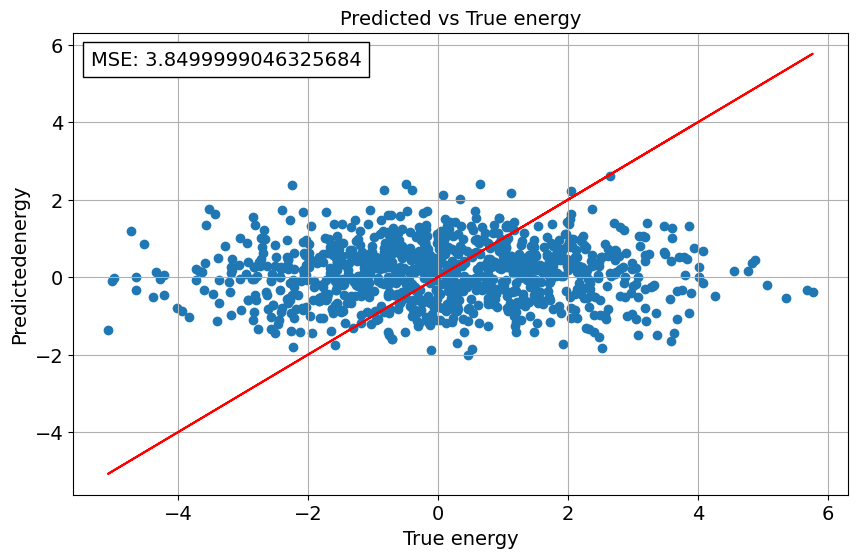

Finished training for dataset with dimension with 40 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 2.4576 	| Test Loss 2.33965
Ep 2 	| Loss 2.4309 	| Test Loss 2.34463
Ep 3 	| Loss 2.40407 	| Test Loss 2.39141
Ep 4 	| Loss 2.34802 	| Test Loss 2.36327
Ep 5 	| Loss 2.23898 	| Test Loss 2.39779
Early stopping at epoch 6


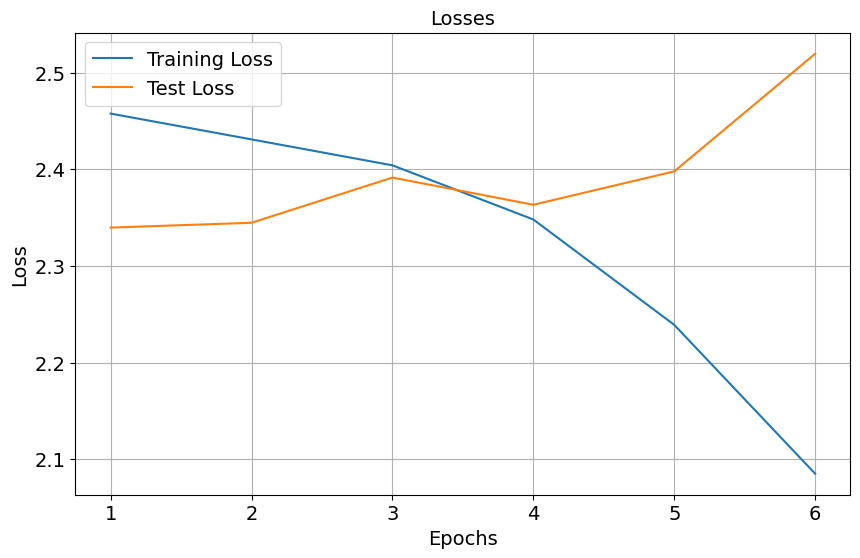

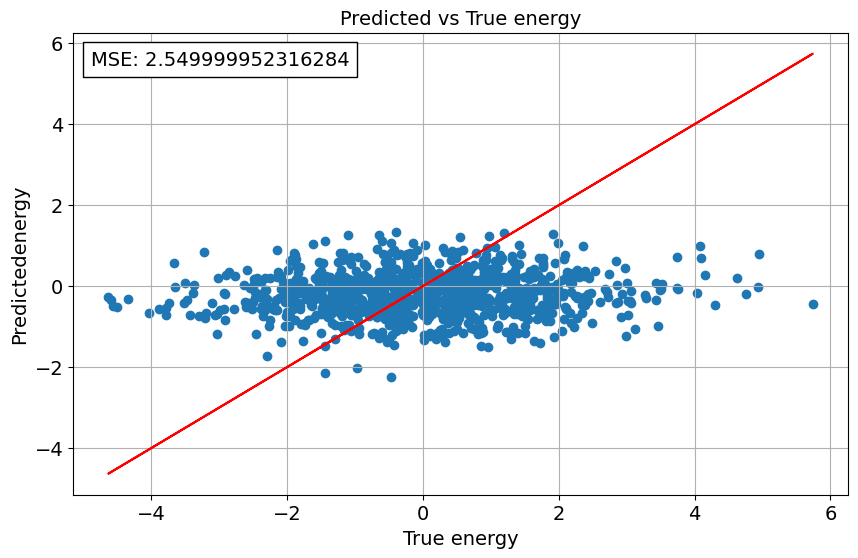

Finished training for dataset with dimension with 30 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 3.80315 	| Test Loss 3.80896
Ep 2 	| Loss 3.78304 	| Test Loss 3.83542
Ep 3 	| Loss 3.7126 	| Test Loss 3.8662
Ep 4 	| Loss 3.51674 	| Test Loss 4.03973
Ep 5 	| Loss 3.22248 	| Test Loss 4.26972
Early stopping at epoch 6


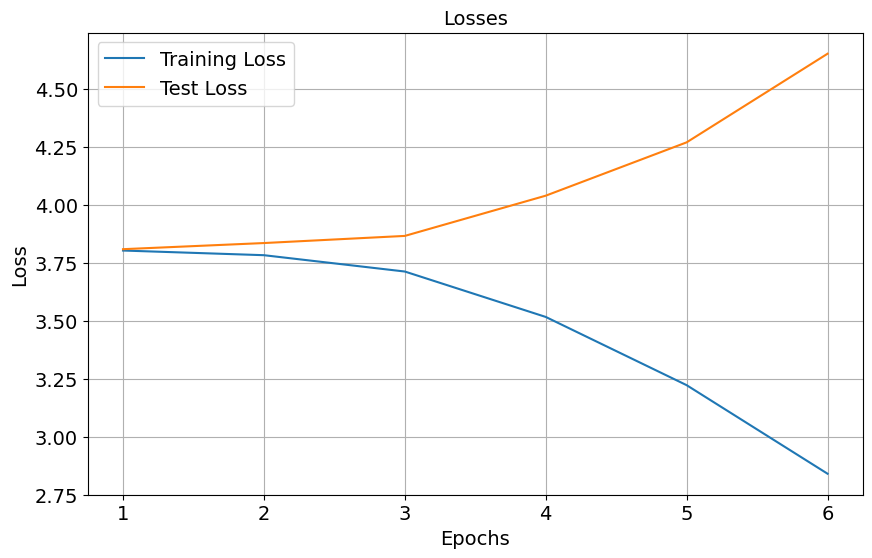

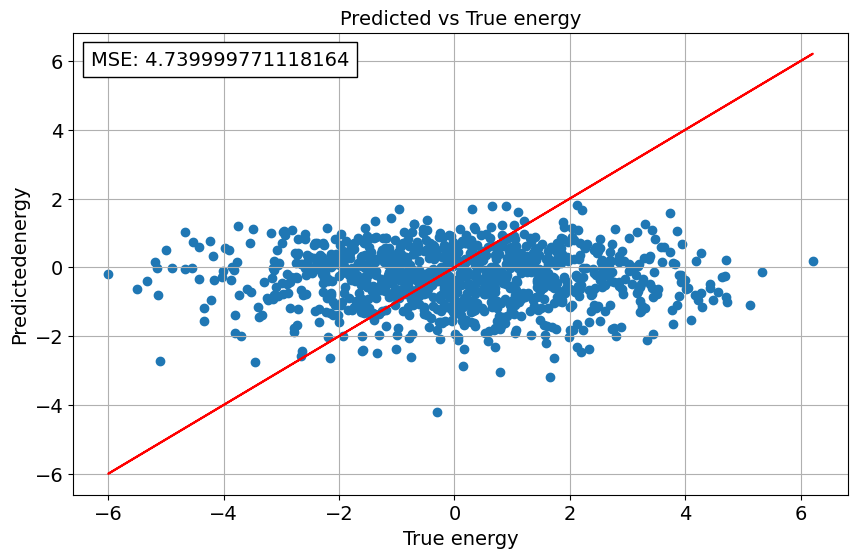

Finished training for dataset with dimension with 45 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
Training ...
Ep 1 	| Loss 2.99076 	| Test Loss 3.06557
Ep 2 	| Loss 2.96254 	| Test Loss 3.10778
Ep 3 	| Loss 2.90301 	| Test Loss 3.18913
Ep 4 	| Loss 2.79477 	| Test Loss 3.22181
Ep 5 	| Loss 2.55187 	| Test Loss 3.39652
Early stopping at epoch 6


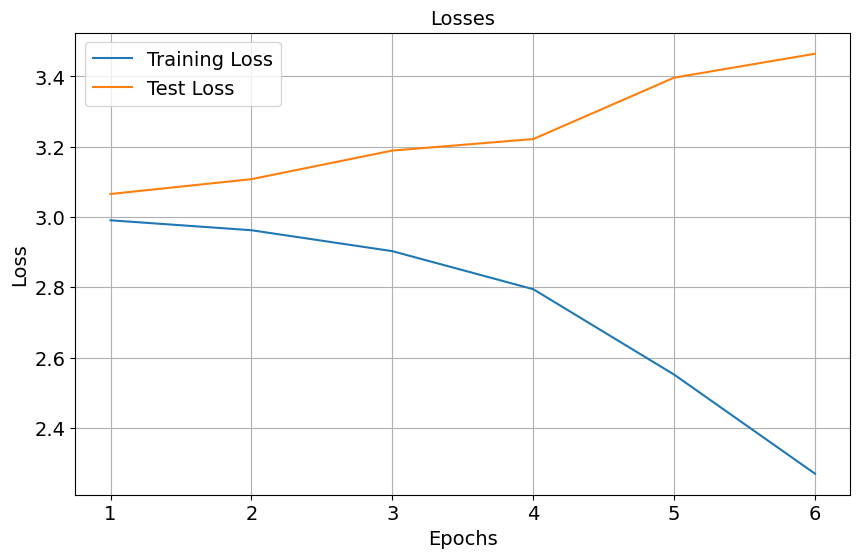

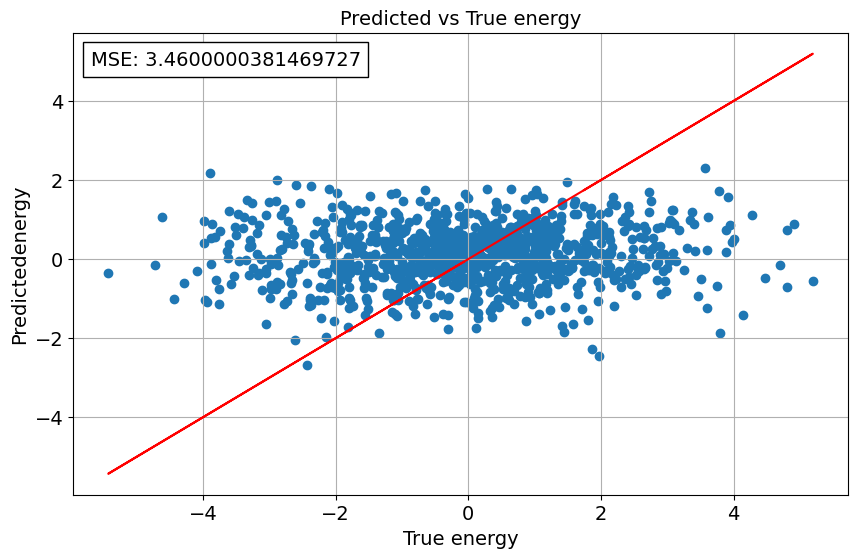

Finished training for dataset with dimension with 35 connections
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------


In [76]:
mse_list = []

for i, (train_loader, test_loader) in enumerate(zip(trainloader_list, testloader_list)):

    model = MLP(in_channels= input_channels, # define the model 
                hidden_channels_1=hidden_channels_1, 
                hidden_channels_2=hidden_channels_2,
                hidden_channels_3=hidden_channels_3,
                out_channels=1,
                dropout=dropout,
                lr=lr,
                wd=weight_decay,
                hidden_layers=hidden_layers
                )
    model.to(device)


    train_losses, test_losses = train_MLP(model, train_loader, test_loader, num_epochs, patience, verbose=True, device=device)
    fig = plot_loss(train_losses, test_losses)
    fig.savefig(f"MLP_energy_{n_connections_list[i]}_connections_loss.png")
    fig, mse = test_trained_model(model, test_loader, device=device)
    fig.savefig(f"MLP_energy_{n_connections_list[i]}_connections_scatter.png")
    mse_list.append(mse)

    print(f"Finished training for dataset with dimension with {n_connections_list[i]} connections")
    print("---------------------------------------------------------")
    print("---------------------------------------------------------")
    print("---------------------------------------------------------")

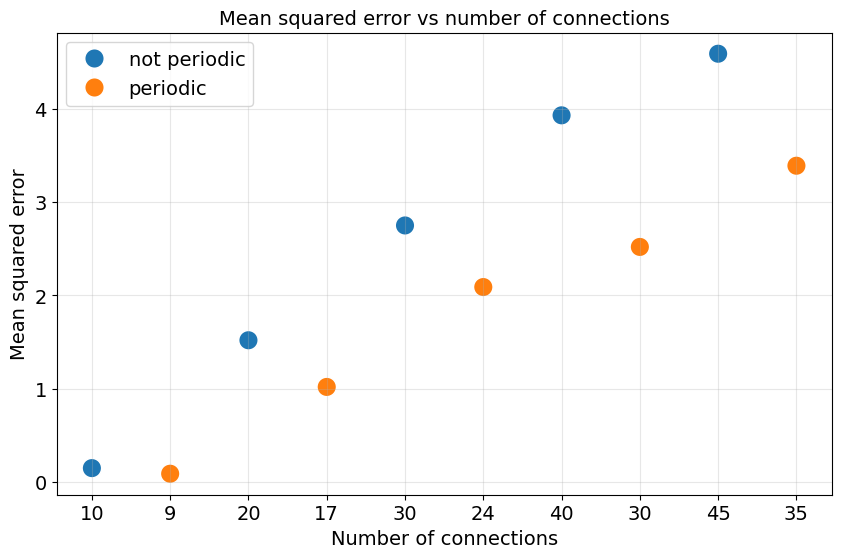

In [72]:
# plot the mse vs the number of connections
fig = plt.figure()
# set a label for even positions on list_n_connections
labels = ["not periodic" if i%2 == 0 else "periodic" for i in np.arange(len(n_connections_list))]


sns.scatterplot(x = np.arange(len(n_connections_list)), y= mse_list, hue=labels, size=labels, sizes=(200, 200) )

plt.xlabel('Number of connections')
plt.ylabel('Mean squared error')
plt.title('Mean squared error vs number of connections')
plt.xticks(np.arange(len(n_connections_list)),n_connections_list)
plt.grid(alpha=0.3)


plt.show(fig)
fig.savefig(f"mse_vs_connections_{n_samples}_MLP.png")
